# QMF: Final Project

*By Basri, Clara, Daniel, Elisa, José, Karim, Nani*

In [97]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [121]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Ubuntu',
    'font.monospace': 'Ubuntu Mono',
    'font.size': 14,

    'axes.labelweight': 'bold',
    'axes.labelcolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlesize': 18,
    'axes.titlelocation': 'center',
    'axes.labelpad': 10,
    'axes.titlepad': 15,
    
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    
    'figure.titlesize': 18,
    'figure.figsize': (10, 6),
    'figure.autolayout': True,
    'figure.subplot.wspace': 0.25,
    'figure.subplot.wspace': 0.4,

    'lines.linewidth': 2
})

## Loading Data

In [124]:
# load stocks from yahoo finance
stocks = yf.download(
    "BNP.PA ACA.PA GLE.PA CS.PA AMUN.PA CNP.PA ^STOXX50E",
    start="2017-06-01")['Close']

# calculate daily returns
returns = (stocks / stocks.shift(1) - 1)

# format date column and drop nan values
stocks = stocks.reset_index().rename(columns = {'Date': 'date'})
returns = returns.dropna().reset_index().rename(columns = {'Date': 'date'})

[*********************100%***********************]  7 of 7 completed


In [125]:
df_covid_vaccines = pd.read_csv("./datasets/covid_vaccines.csv", sep=';', usecols=['reg', 'jour', 'n_cum_dose1', 'n_cum_complet', 'n_cum_rappel'], parse_dates=['jour'])
df_covid_vaccines.rename(columns={'reg': 'region', 'jour': 'date', 'n_cum_dose1': 'n_first_dose', 'n_cum_complet': 'n_second_dose', 'n_cum_rappel': 'n_third_dose'}, inplace=True)
df_covid_vaccines = df_covid_vaccines.groupby(by='date').sum().drop(columns=['region'])

In [126]:
df_covid_vaccines = pd.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/fa4ad329-14ec-4394-85a4-c5df33769dff", 
    sep=';', 
    names=['fra', 'date', '_', '__', '___', 'n_first_dose', 'n_second_dose', 'n_third_dose', '____', '_____', '______'], 
    usecols=['fra', 'date', 'n_first_dose', 'n_second_dose', 'n_third_dose'], 
    skiprows=1, 
    parse_dates=['date']
)

In [127]:
df_covid_indicators = pd.read_csv(
    "https://www.data.gouv.fr/fr/datasets/r/f335f9ea-86e3-4ffa-9684-93c009d5e617", 
    usecols=['date', 'dc_tot', 'conf_j1', 'TO', 'R'],  
    parse_dates=['date']
)
df_covid_indicators.rename(columns={'date': 'date', 'dc_tot': 'n_deaths', 'conf_j1': 'n_new_cases', 'TO': 'hosp_occupation_rate', 'R': 'virus_reproduction_factor'}, inplace=True)
df_covid_indicators.fillna(0, inplace=True)

## Data Processing

### Calculate Abnormal Returns

In [128]:
window = 253
abn_returns = pd.DataFrame(index = returns.date)
banks = ['ACA.PA', 'AMUN.PA', 'BNP.PA', 'CNP.PA', 'CS.PA', 'GLE.PA']

for bank in banks:
    for t in range(window, len(returns)):
        past_values = returns.iloc[t-window:t-2]
        past_values['const'] = 1
        
        results = sm.OLS(past_values[bank], past_values[['const', '^STOXX50E']]).fit()
        alpha = results.params[0]
        beta = results.params[1]

        current_date = returns['date'].iloc[t]
        abn_returns.loc[current_date, bank] = returns[bank].iloc[t] - alpha - beta*returns['^STOXX50E'].iloc[t]

abn_returns = abn_returns.dropna()
abn_returns['avg'] = abn_returns.mean(axis=1)
abn_returns['cum'] = abn_returns['avg'].rolling(window=window).mean()
abn_returns = abn_returns.reset_index()

/home/josebarretto/anaconda3/envs/ftd/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


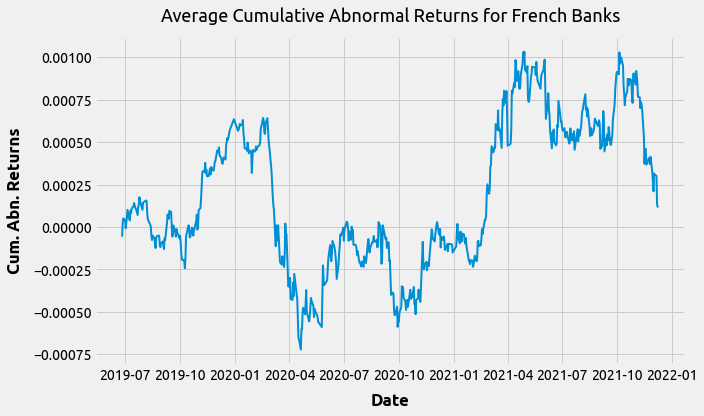

In [129]:
# plot abnormal returns
plt.figure()

plt.title('Average Cumulative Abnormal Returns for French Banks')
plt.plot(abn_returns['date'], abn_returns['cum'])
plt.ylabel('Cum. Abn. Returns')
plt.xlabel('Date')

plt.show()